# Challenge 2 - Getting started <img align="right" src="../Supplementary_data/EY_logo.png" style="margin:0px 50px">

Welcome to the 2020 NextWave Data Science Challenge!  Thank you for taking part in the private challenge and helping us test and improve the student experience.

We have prepared a small initial dataset for you to start flexing your data science muscles. We are hoping you will be able to open and view some data, create a basic solution to the problem, and submit your results via the EY Data Science platform.

## Registering for the challenge and getting the data

Prior to running this notebook, make sure you have:
* **Completed Challenge 1** as you will need to use your methodology from Challenge 1 to complete Challenge 2
* **Registered** for the "NextWave Bushfire Challenge Phase 2 - Detect fire edges in satellite images" on the [EY Data Science Platform](http://datascience.cognistreamer.com/) 
* **Downloaded and extracted** the "Challenge2_v1.zip.zip" file under "Additional data" from the Challenge page on the Platform
* **Uploaded** the contents of the .zip file into your jupyter environment, in the "04_EY_challenge2" folder.

Your folder structure should look like the below:

<img src="../Supplementary_data/EY_Challenge2_Getting_started/folder_structure.PNG">

To check you have executed this correct, execute the code cell below and compare the contents of your current working directory (where this notebook is executing from) to the image above. You should see:

* `/home/jovyan/04_EY_challenge2` showing you are working in the "04_EY_challenge2" folder.

* `['.ipynb_checkpoints', 'EY_Challenge2_Getting_started.ipynb', 'input_linescan', 'test.csv', 'tgt_mask', 'train.csv', 'world']` showing the contents of the folder.

In [1]:
import os
print(os.getcwd())
print(os.listdir())

/home/jovyan/04_EY_challenge2
['.ipynb_checkpoints', 'EY_Challenge2_Getting_started_v1-testing fire example.ipynb', 'EY_Challenge2_Getting_started_v1.ipynb', 'example of cloud mask.ipynb', 'input_linescan', 'test_v1.csv', 'tgt_mask', 'tmp1.tif', 'tmp2.tif', 'train_v1.csv', 'world']


## A quick word on the data

Like in Challenge 1, we have provided linescan (and associated world files) which show images of fires collected from a plane.

Unlike in Challenge 1, in Challenge 2 we have not provided the target masks for you. You have to create these from the linescans using your methodology or model from Challenge 1.

All the linescans chosen for this dataset align with satellite passes (within 4 hours). Once you have created target masks from the linescans, your task is to use the available satellite data and the masks you contructed to train a model or process which can produce a mask from satellite data. Note that the test coordinates you are asked to predict do not fall within the linescan files provided, but do align with satellite passes.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import xarray as xr

import datacube
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from skimage import io
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage import measure

from affine import Affine
from rasterio.plot import show, show_hist
# from rasterio.transform import from_bounds

sys.path.append("../scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices

### Import input variable: aerial linescan images

In [3]:
file_stem = 'NUNNETT 174 P1_201901251128_MGA94_55'
raster_filename = 'input_linescan/' + file_stem + '.jpg'
world_filename = 'world/'  + file_stem + '.bqw'

In [4]:
ls = rasterio.open(raster_filename, mode='r+')

a, d, b, e, c, f = np.loadtxt(world_filename)    # order depends on convention
transform = Affine(a, b, c, d, e, f)
crs = rasterio.crs.CRS({"init": "epsg:28355"})     # "epsg:4326"  WGS 84,  or whatever CRS you know the image is in

ls.transform = transform
ls.crs = crs

Dataset has no geotransform set. The identity matrix may be returned.


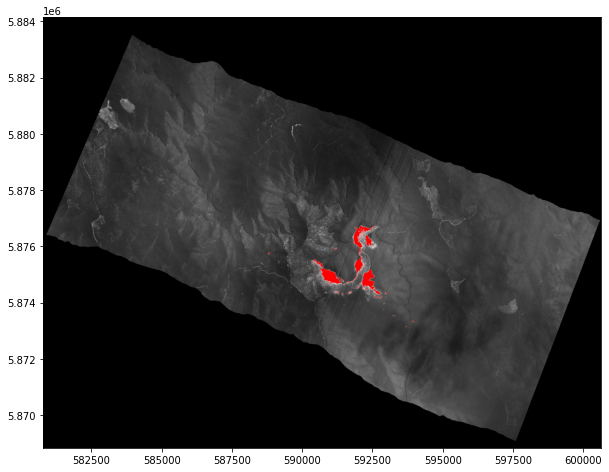

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

show(ls.read(), transform=ls.transform, ax=ax)

### Create a target mask
Using the methodology you developed in challenge 1, create a target mask from the linescan. For this example, we are using the same `get_mask` function defined in the "EY Challenge1 - Getting started" notebook, but renamed it to show that we are getting a mask based on a linescan input image rather than a satellite input image.

In [6]:
def get_mask_from_ls(img, thresh):
    r = img.read(1)
    r[r < thresh] = 0
    lum = color.rgb2gray(r)
    mask1 = morphology.remove_small_objects(lum, 50)
    mask2 = morphology.remove_small_holes(mask1, 5)
    mask3 = morphology.opening(mask2, morphology.disk(3))
    mask3[mask3 > 0 ] = 255
    return mask3.astype(np.uint8)

In [7]:
tgt_filename = 'tgt/' + file_stem + '.jpg'

In [8]:
# create a mask using the process we developed earlier. For this example, provide the same threshold for all linescans
tgt_raw = get_mask_from_ls(ls, 150) # note this is a numpy array and is not georeferenced

# create a dataset for georeferencing and storing the array
tgt = rasterio.open(
    'tmp1.tif',
    mode='w+',
    driver='GTiff',
    height=tgt_raw.shape[0],
    width=tgt_raw.shape[1],
    count=1,
    dtype=tgt_raw.dtype,
    crs=ls.crs,
    transform=ls.transform)

# copy the array into the opened dataset
tgt.write(tgt_raw, 1)

The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


Plotting the linescan and the mask together allows us to take a look at how they compare.

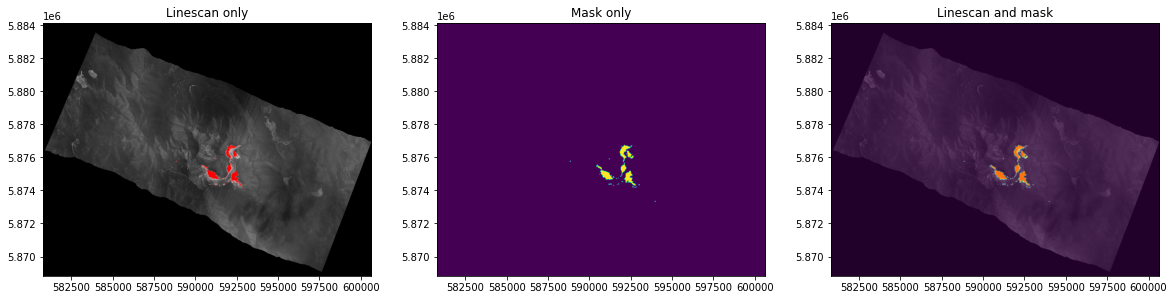

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20,20))

ax[0].set_title('Linescan only')
show(ls.read(), transform=ls.transform, ax=ax[0])

ax[1].set_title('Mask only')
show(tgt.read(), transform=tgt.transform, ax=ax[1])

ax[2].set_title('Linescan and mask')
show(ls.read(), transform=ls.transform, ax=ax[2])
show(tgt.read(), transform=tgt.transform, ax=ax[2], alpha=0.5)

It looks like the clouds have been mistakenly labelled as fire by our method, and we have missed the gaps where the fire has already burnt out, but it's not too bad. Hopefully your work in Challenge 1 will create a more accurate mask than this example solution!

You can create masks for all five input linescans and save them in a folder. We can then call on them to train our model for Challenge 2. A more memory-efficient way to do this might be to create a mask '"on-the-fly" during model training, however since our dataset is only small, we will just create them all now. You'll also probably want to check each of them individually in case you can improve the accuracy some more.

In [10]:
train = pd.read_csv('train_v1.csv')
fnames = train.stem
fnames

0    MACALISTER 501 P1_201903021337_MGA94_55
1       NUNNETT 132 P1_201901201157_MGA94_55
2       NUNNETT 174 P1_201901251128_MGA94_55
3       NUNNETT 182 P1_201901251321_MGA94_55
4       NUNNETT 393 P1_201902221446_MGA94_55
Name: stem, dtype: object

In [11]:
for file_stem in fnames:
    
    # open the raster file and georeference with the corresponding world file
    raster_filename = 'input_linescan/' + file_stem + '.jpg'
    world_filename = 'world/'  + file_stem + '.bqw'
    tgt_filename = 'tgt_mask/'  + file_stem + '.tif'
    ls = rasterio.open(raster_filename, mode='r+')
    a, d, b, e, c, f = np.loadtxt(world_filename)    # order depends on convention
    transform = Affine(a, b, c, d, e, f)
    crs = rasterio.crs.CRS({"init": "epsg:28355"})     # "epsg:4326"  WGS 84,  or whatever CRS you know the image is in
    ls.transform = transform
    ls.crs = crs
    
    # create a mask using the process we developed earlier. For this example, provide the same threshold for all linescans
    tgt_raw = get_mask_from_ls(ls, 100)

    # create a dataset for storing the array
    tgt = rasterio.open(
        tgt_filename,
        mode='w+',
        driver='GTiff',
        height=tgt_raw.shape[0],
        width=tgt_raw.shape[1],
        count=1,
        dtype=tgt_raw.dtype,
        crs=ls.crs,
        transform=ls.transform)

    # copy the array into the opened dataset
    tgt.write(tgt_raw, 1)
    
    tgt.close()

The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


### Get satellite data
Now that we have our target data (masks), we need to get our source data (satellite images). We can use the metadata from the extent and file name of each target image to find satellite imagery of approximately the same time and place.

In [13]:
# clear some memory
# %whos

In [14]:
dc = datacube.Datacube(app="Burnt_area_mapping")

In [15]:
file_stem = 'NUNNETT 174 P1_201901251128_MGA94_55'
raster_filename = 'input_linescan/' + file_stem + '.jpg'
world_filename = 'world/'  + file_stem + '.bqw'
tgt_filename = 'tgt_mask/'  + file_stem + '.tif'

In [16]:
dates_baseline = ('2018-12-01', '2018-12-31') # 1 month period preceeding fire event
dates_fire = ('2019-01-24', '2019-01-25') # retrieved from fire name

We strongly recommend you check out the other notebooks available in this jupyter environment prior to continuing, as they explain the query structure and datasets that are returned from the open data cube, plus some tips relevant to identifying bushfire. We are using the Normalise Burn Ratio (NBR) in this example methodolgy. Review the `Burnt_area_mapping` notebook in the "Real World Examples" folder to learn more about the NBR product.

In [17]:
ls = rasterio.open(raster_filename, mode='r+')
a, d, b, e, c, f = np.loadtxt(world_filename)    # order depends on convention
transform = Affine(a, b, c, d, e, f)
crs = rasterio.crs.CRS({"init": "epsg:28355"})     # "epsg:4326"  WGS 84,  or whatever CRS you know the image is in
ls.transform = transform
ls.crs = crs

tgt = rasterio.open(tgt_filename, mode='r')
tgt.bounds

Dataset has no geotransform set. The identity matrix may be returned.


BoundingBox(left=580775.0, bottom=5868834.8, right=600622.6, top=5884141.0)

Note: some of the linescans provided intersect with Landsat-7 or Landsat-8 rather than Sentinel-2. Also, the timestamps in the linescan file names are in local time, however the Open Data Cube stores data in UTC time, so you may need to adjust the dates you in your query to return the most relevant (timely) data.

In [18]:
query = {
    "resolution": (-10, 10),
    "products": ['ga_s2a_ard_nbar_granule', 'ga_s2b_ard_nbar_granule'],
    "measurements": ['nbar_blue', 'nbar_green', 'nbar_red', 'nbar_nir_1', 'nbar_swir_3'],
    "crs": 'epsg:28355',
    "output_crs": 'epsg:28355',
    "mask_pixel_quality": False,
    "group_by": 'solar_day'}

min_gooddata=0.5 # only used for baseline given that smoke causes low pixel quality during the fire

In [19]:
baseline = load_ard(dc=dc,
                    x=(tgt.bounds.left, tgt.bounds.right),
                    y=(tgt.bounds.bottom, tgt.bounds.top),
                    time=dates_baseline,
                    min_gooddata=min_gooddata,
                    **query)

baseline = calculate_indices(baseline, index='NBR', collection='ga_s2_1', drop=False)
baseline_mean = baseline.median(dim='time')
baseline_NBR = baseline_mean.NBR


fire = load_ard(dc=dc,
                x=(tgt.bounds.left, tgt.bounds.right),
                y=(tgt.bounds.bottom, tgt.bounds.top),
                time=dates_fire,
                **query)

fire = calculate_indices(fire, index='NBR', collection='ga_s2_1', drop=False)
fire_mean = fire.median(dim='time')
fire_NBR = fire_mean.NBR


delta_NBR = baseline_NBR - fire_NBR

Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Counting good quality pixels for each time step
Filtering to 5 out of 13 time steps with at least 50.0% good quality pixels
Loading 5 time steps
Finding datasets
    ga_s2a_ard_nbar_granule
    ga_s2b_ard_nbar_granule
Loading 1 time steps


In [20]:
b_start = pd.to_datetime(baseline.time[0].values) 
b_end = pd.to_datetime(baseline.time[-1].values)
f_time = pd.to_datetime(fire.time[0].values)

ls_time = '2019-01-25 01:28' # note this is in UTC time, not local time as per the file name

Text(0.5, 0, 'x [metres]')

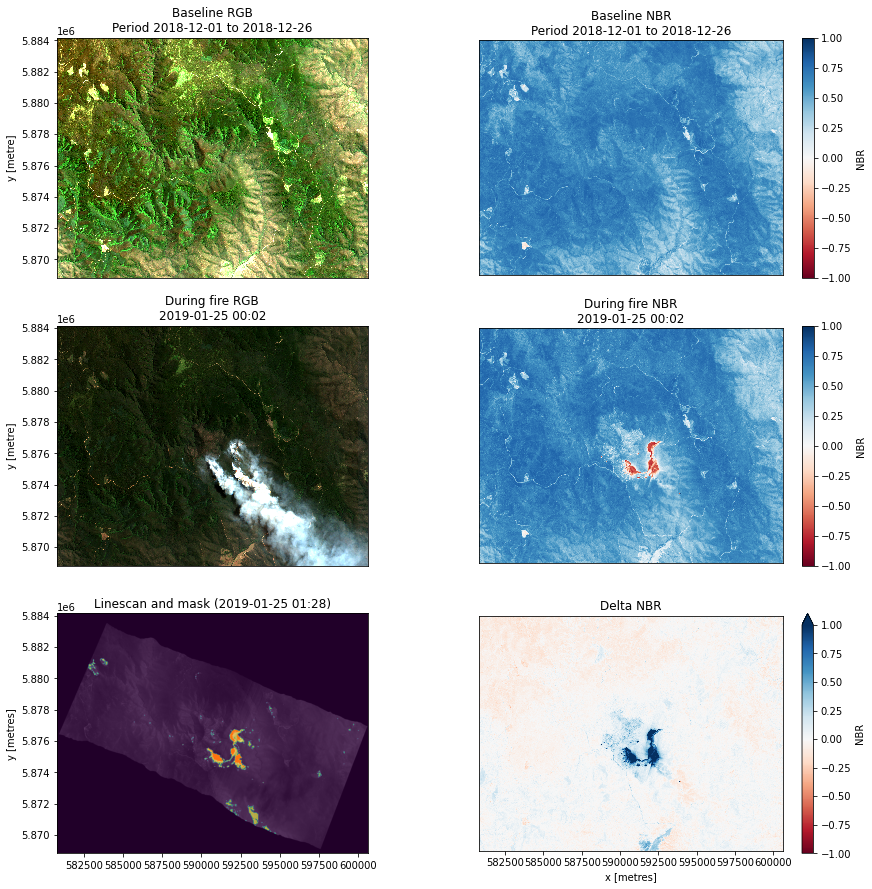

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Visualise baseline image as a true colour image
rgb(baseline_mean, bands=['nbar_red', 'nbar_green', 'nbar_blue'], ax=axs[0, 0])
axs[0, 0].set_aspect(aspect='equal')
axs[0, 0].set_title(f'Baseline RGB\nPeriod {b_start.strftime("%Y-%m-%d")} to {b_end.strftime("%Y-%m-%d")}')
axs[0, 0].xaxis.set_visible(False)

# Visualise baseline image as NBR image
baseline_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axs[0, 1])
axs[0, 1].set_aspect(aspect='equal')
axs[0, 1].set_title(f'Baseline NBR\nPeriod {b_start.strftime("%Y-%m-%d")} to {b_end.strftime("%Y-%m-%d")}')
axs[0, 1].yaxis.set_visible(False)
axs[0, 1].xaxis.set_visible(False)

# Visualise during-fire image as a true colour image
rgb(fire_mean, bands=['nbar_red', 'nbar_green', 'nbar_blue'], ax=axs[1, 0])
axs[1, 0].set_aspect(aspect='equal')
axs[1, 0].set_title(f'During fire RGB\n{f_time.strftime("%Y-%m-%d %H:%M")}')
axs[1, 0].xaxis.set_visible(False)

# Visualise during-fire image as NBR image
fire_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axs[1, 1])
axs[1, 1].set_aspect(aspect='equal')
axs[1, 1].set_title(f'During fire NBR\n{f_time.strftime("%Y-%m-%d %H:%M")}')
axs[1, 1].yaxis.set_visible(False)
axs[1, 1].xaxis.set_visible(False)

# Visualise linescan and mask
show(ls.read(), transform=ls.transform, ax=axs[2,0])
show(tgt.read(), transform=tgt.transform, ax=axs[2,0], alpha=0.5)
axs[2, 0].set_aspect(aspect='equal')
axs[2, 0].set_title(f'Linescan and mask ({ls_time})')
axs[2, 0].set_ylabel('y [metres]');

# Visualise delta NBR image
delta_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axs[2, 1])
axs[2, 1].set_aspect(aspect='equal')
axs[2, 1].set_title(f'Delta NBR')
axs[2, 1].yaxis.set_visible(False)
axs[2, 1].set_xlabel('x [metres]')

The smoke obstructs the visible wavelengths more than the infrared wavelengths. Exploiting the differences using the NBR product allows us to get a better picture of where the fire is in the satellite image.

Our goal is to generate a mask showing pixels on fire and not on fire from the satellite data. One way we could do this is by thresholding the delta NBR values similar to the example approach in Challenge 1.

In [20]:
threshold = 0.5
mask_raw = np.uint8(xr.where(delta_NBR > threshold, 1, 0))

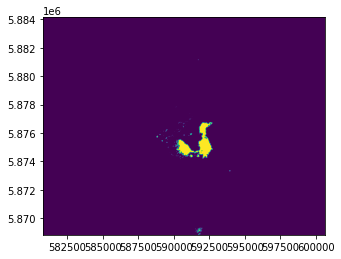

In [21]:
transform = rasterio.transform.from_bounds(west=delta_NBR.x.values[0],
                                           south=delta_NBR.y.values[-1],
                                           east=delta_NBR.x.values[-1],
                                           north=delta_NBR.y.values[0],
                                           width=delta_NBR.shape[1],
                                           height=delta_NBR.shape[0])

# create a temporary dataset for storing the array
mask = rasterio.open(
    'tmp2.tif',
    mode='w+',
    driver='GTiff',
    height=mask_raw.shape[0],
    width=mask_raw.shape[1],
    count=1,
    dtype=mask_raw.dtype,
    crs=tgt.crs,
    transform=transform)

# copy the array into the opened dataset
mask.write(mask_raw, 1)

show(mask.read(), transform = mask.transform)

# mask.close()

Comparing the mask generated from the satellite image against the one generated from the linescan (which we are treating as the target variable) we can see that they are similar.

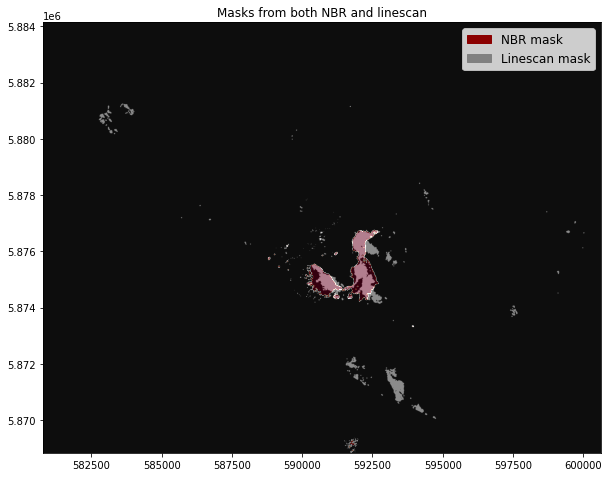

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.set_title('Masks from both NBR and linescan')
plt_nbrMask = show(mask.read(), transform=mask.transform, ax=ax, cmap="RdGy_r", label='Mask from NBR')
plt_linescanMask = show(tgt.read(), transform=tgt.transform, ax=ax, alpha=0.5, cmap="gray", label='Mask from NBR')
ax.set_aspect(aspect='equal')

# Add a legend for labels
legend_labels = {"darkred": "NBR mask", "gray": "Linescan mask"}
patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]
ax.legend(handles=patches,fontsize='large')

plt.show()

### Making a submission
The "test.csv" file provides a list of 2000 coordinates that require classification at two additional fire observations where linescans have not been provided. Note that the coordinates are denoted in the CRS mentioned above, epsg:28355. Follow the same process described in the Challenge 1 example notebook to create a submission.

***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question in the [Troubleshooting EY Data Science Program MS Teams Channel](https://teams.microsoft.com/l/channel/19%3a90804a73cb5a4159a60693c41a8820d2%40thread.tacv2/Troubleshooting?groupId=f6acd945-fed9-4db4-bed8-414988473a36&tenantId=5b973f99-77df-4beb-b27d-aa0c70b8482c) or on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020